# 순차적 앙상블 학습 (Sequential Ensemble Learning) 기초

이 노트북은 부스팅(Boosting) 계열의 앙상블 모델들의 기초를 다룹니다. `scikit-learn`의 기본 부스팅 모델부터 `XGBoost`, `LightGBM`, `CatBoost`까지 핵심적인 알고리즘들을 예제를 통해 학습합니다.

**학습 목표:**
1. 부스팅 앙상블의 기본 개념 이해
2. 각 부스팅 모델 라이브러리의 기본 사용법 숙지
3. 하이퍼파라미터 튜닝을 통한 모델 복잡도 제어 이해
4. Feature Importance 및 Partial Dependence Plot을 통한 모델 결과 해석

## 1. 라이브러리 설치 및 데이터 준비

먼저 예제에 필요한 라이브러리를 설치합니다. `xgboost`, `lightgbm`, `catboost`는 별도 설치가 필요합니다.

### 1.1. Iris 데이터셋 (분류 예제)

붓꽃(Iris) 품종 분류를 위해 데이터를 불러오고, 머신러닝 모델이 이해할 수 있도록 타겟 변수(`species`)를 `LabelEncoder`를 사용해 숫자(0, 1, 2)로 변환합니다. 그 후, 모델 성능 평가를 위해 데이터를 훈련용과 테스트용으로 분리합니다.

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# 데이터 로드
iris = sns.load_dataset('iris')
X = iris.drop('species', axis=1)
y_str = iris['species']

# 타겟 변수 라벨 인코딩
classle = LabelEncoder()
y = classle.fit_transform(y_str)

# 훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

print(f"훈련 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")

훈련 데이터 크기: (105, 4)
테스트 데이터 크기: (45, 4)


## 2. 기본 앙상블: Voting Classifier

부스팅을 배우기 전에, 여러 다른 종류의 모델을 결합하는 간단한 앙상블 기법인 **Voting**을 먼저 살펴보겠습니다. 로지스틱 회귀, 랜덤 포레스트, SVM 이라는 세 가지 다른 모델을 학습시킨 후, 각 모델의 예측 결과를 다수결로 합쳐 최종 예측을 결정합니다.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_cl = LogisticRegression(random_state=1)
rf_cl = RandomForestClassifier(random_state=1)
svm_cl = SVC(random_state=1)

# VotingClassifier의 estimators는 (이름, 모델) 형태의 튜플 리스트로 전달해야 합니다.
voting_cl = VotingClassifier(
    estimators=[('lr', log_cl), ('rf', rf_cl), ('svc', svm_cl)],
    voting='hard' # hard voting: 다수결 원칙
)

for cl in (log_cl, rf_cl, svm_cl, voting_cl):
    cl.fit(X_train, y_train)
    y_pred = cl.predict(X_test)
    print(f"{cl.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}")

LogisticRegression: 0.9778
RandomForestClassifier: 0.9778
SVC: 0.9778
VotingClassifier: 0.9778


### 분석
위 코드 실행 결과, 개별 모델과 보팅 앙상블 모델의 정확도가 출력됩니다. Iris 데이터는 비교적 분류가 쉬운 문제라 모든 모델이 높은 성능을 보일 수 있습니다. 하지만 더 복잡한 문제에서는 보팅 앙상블이 개별 모델보다 더 안정적이거나 높은 성능을 보이는 경우가 많습니다.

## 3. 부스팅 모델 (Boosting Models)

이제 본격적으로 순차적 앙상블 모델인 부스팅 계열을 다뤄보겠습니다.

### 3.1. AdaBoost (Adaptive Boosting)

AdaBoost는 부스팅 알고리즘의 시초 중 하나로, 이전 모델이 잘못 예측한 데이터에 가중치를 부여하여 다음 모델이 해당 데이터를 더 집중적으로 학습하도록 만드는 방식입니다. 여기서는 약한 학습기(weak learner)로 `max_depth=2`인 간단한 결정 트리를 사용합니다.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=500,
    learning_rate=0.1, # SAMME.R 알고리즘을 사용하므로 learning_rate 조절 가능
    random_state=1
)

ada_clf.fit(X_train, y_train)

y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

ada_train_acc = accuracy_score(y_train, y_train_pred)
ada_test_acc = accuracy_score(y_test, y_test_pred)

print(f"AdaBoost Train/Test Accuracy: {ada_train_acc:.3f}/{ada_test_acc:.3f}")

AdaBoost Train/Test Accuracy: 1.000/0.978


### 분석
훈련 데이터 정확도(Train Accuracy)는 매우 높게 나타나고, 테스트 정확도(Test Accuracy)는 그보다 조금 낮게 나타날 수 있습니다. 만약 두 값의 차이가 크다면 모델이 훈련 데이터에 과적합되었을 가능성을 의미합니다. `learning_rate`나 `n_estimators`를 조절하여 과적합을 제어할 수 있습니다.

### 3.2. Gradient Boosting Machine (GBM)

GBM은 AdaBoost와 달리, 이전 단계 모델의 잔차(residual)를 다음 모델이 학습하는 방식으로 동작합니다. 경사 하강법(Gradient Descent) 원리를 사용하여 손실 함수를 최소화하는 방향으로 모델을 순차적으로 추가해 나갑니다.

#### 3.2.1. Boston 주택 가격 데이터셋 (회귀 예제)

이제부터는 회귀 문제를 다루기 위해 Boston 주택 가격 데이터셋을 사용하겠습니다. 데이터셋의 각 변수는 주택 가격에 영향을 미치는 요인들을 나타냅니다.

In [4]:
import pandas as pd

# scikit-learn 1.2 버전부터는 ISLP 대신 내장 함수 사용을 권장합니다.
try:
    from sklearn.datasets import fetch_openml
    boston = fetch_openml(name='boston', version=1, as_frame=True)
    house = boston.frame
    X = house.drop('MEDV', axis=1)
    y = house['MEDV']
except ImportError:
    # 이전 버전 호환용 코드
    from sklearn.datasets import load_boston
    boston = load_boston()
    X = pd.DataFrame(boston.data, columns=boston.feature_names)
    y = pd.Series(boston.target, name='MEDV')
    house = X.copy()
    house['MEDV'] = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
house.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- crim: per capita crime rate by town.

- zn: proportion of residential land zoned for lots over 25,000 sq.ft.

- indus: proportion of non-retail business acres per town.

- chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- nox: nitrogen oxides concentration (parts per 10 million).

- rm: average number of rooms per dwelling.

- age: proportion of owner-occupied units built prior to 1940.

- dis: weighted mean of distances to five Boston employment centres.

- rad: index of accessibility to radial highways.

- tax: full-value property-tax rate per $10,000.

- ptratio: pupil-teacher ratio by town.

- lstat: lower status of the population (percent).

- **medv** (target): median value of owner-occupied homes in $1000s.

#### 3.2.2. GBM 회귀 모델 학습 및 최적 트리 개수 탐색

`staged_predict` 메서드는 앙상블에 트리가 하나씩 추가될 때마다의 예측값을 반환합니다. 이를 이용하면 매번 모델을 다시 학습시키지 않고도 최적의 `n_estimators` (트리 개수)를 효율적으로 찾을 수 있습니다.

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gb_reg = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=0.1, random_state=1)
gb_reg.fit(X_train, y_train)

# staged_predict를 이용해 최적의 트리 개수(M) 찾기
errors = [mean_squared_error(y_test, y_pred) for y_pred in gb_reg.staged_predict(X_test)]
best_n_estimators = np.argmin(errors) + 1

print(f"최적의 트리 개수 (Best M): {best_n_estimators}")

# 최적의 트리 개수로 모델 재학습
gb_best = GradientBoostingRegressor(max_depth=3, n_estimators=best_n_estimators, random_state=1)
gb_best.fit(X_train, y_train)

y_train_pred = gb_best.predict(X_train)
y_test_pred = gb_best.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'GBM RMSE Train: {rmse_train:.3f}, Test: {rmse_test:.3f}')

최적의 트리 개수 (Best M): 98
GBM RMSE Train: 1.224, Test: 2.597


#### 3.2.3. 변수 중요도 (Feature Importance)

변수 중요도는 모델이 예측을 할 때 각 변수가 얼마나 기여했는지를 나타내는 지표입니다. 이를 통해 어떤 변수가 주택 가격에 큰 영향을 미치는지 파악할 수 있습니다.

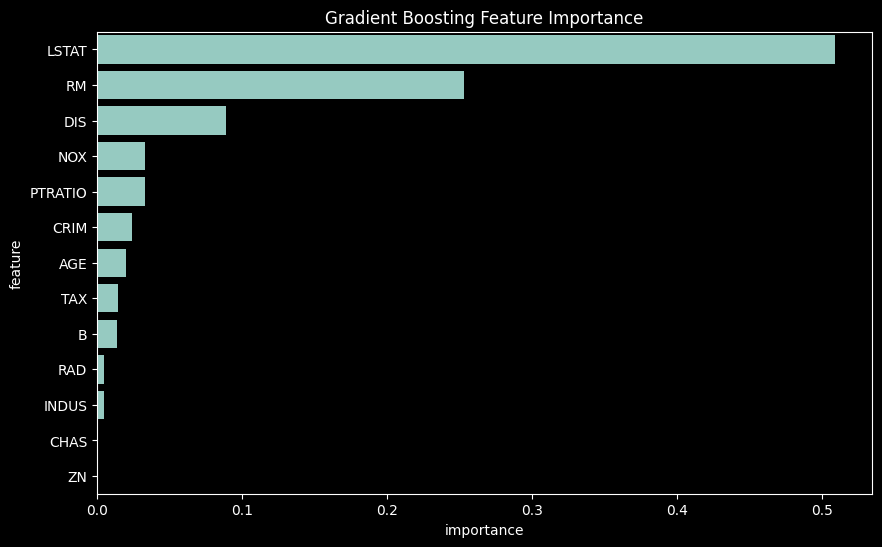

In [6]:
importances = gb_best.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Gradient Boosting Feature Importance')
plt.show()

### 분석
실행 결과, `LSTAT`(저소득층 비율)과 `RM`(주거 당 평균 방 개수)이 주택 가격 예측에 가장 중요한 변수로 나타납니다. 이는 저소득층 비율이 높을수록 집값이 낮아지고, 방의 개수가 많을수록 집값이 높아진다는 직관과 일치합니다.

#### 3.2.4. 부분 의존도 그림 (Partial Dependence Plot, PDP)

PDP는 다른 모든 변수들의 효과를 평균적으로 고정했을 때, 특정 변수 하나가 모델의 예측 결과에 어떤 영향을 미치는지를 시각적으로 보여주는 기법입니다. 변수 중요도가 '무엇'이 중요한지 알려준다면, PDP는 '어떻게' 영향을 미치는지 보여줍니다.

Decision Tree 들의 Ensemble을 통해 다음과 같은 회귀 함수를 만들었다고 가정하자.
$$
y \approx \hat{f}(x_1, x_2, ..., x_p)
$$
다른 구조를 가진 나무들의 combination 이기 때문에 저 함수 $f(\cdot)$ 가 개별 $x_j$ 들이 $y$에 어떻게 영향을 미치는지 그리기 힘들다.


다음을 생각해보자. $j$번째 변수에 대한 값이 하나 주어졌다고 하자. $X_j=x_j$. 위 함수 $f$에 대해 $j$번째 변수를 제외한 나머지는 확률변수 취급해서 이에 대한 expectation을 취해보자.
$$
g_j(x_j) = E_{-j}[f(X_1, X_2, ...,X_{j-1}, x_j, X_{j+1}, \ldots, X_p)]
$$
다시말해, 위 $f(\cdot)$함수에서, $x_j$의 경우는 주어진 값으로 고정하고 나머지 변수들에 대해서만 확률변수로 취급해서 expected out 되도록 한다.

**예 Partial Dependence Plot**

- y: 연봉
- x_1: 몸무게
- x_2: 키

`연봉~f(몸무게, 키)`을 예측하는 함수가 있다고 해보자. 
이때 **몸무게만의 영향**을 보기 위해, 모든 모집단 데이터에 대해 키의 분포를 알고 있다면, 몸무게 값이 주어졌을 때마다 그에 해당하는 연봉은 다음처럼 계산한다. 만약 대한민국사람들의 키의 모집단 분포가 다음과 같고, 주어진 몸무게(60)에서의 예측값이 다음과 같다면,

| x | 160 | 170 | 180 | 190 |
|---|-----|-----|-----|-----|
| p(키=x) | 4/8 | 2/8 | 1/8 | 1/8 |
| f(주어진 몸무게60,x)의 값 (연봉예측값) | 150 | 200 | 300 | 250 |

따라서, 
$$
g_j(몸무게=60) = 150 * 4/8 + 200 * 2/8 + 300 * 1/8 + 250 * 1/8 = 193.75
$$
보통은 이러한 확률분포를 모르기에, partial dependence function의 추정은 다음과 같이 할 수 있다.

$$
\hat{f}_{j}(x_j) = \frac{1}{n} \sum_{i}^n \hat{f}(x_{i1}, x_{i2},\ldots, x_{i,j-1}, x_j, x_{i,j+1}, \ldots, x_{ip})
$$


$j$ 번째 변수에 대해서만 확인해 보았는데, 그 안에 여러 변수를 넣어도 상관 없다. Selected 된 변수들에 대해선 고정하고, 나머진 변수들에 대해선 expected out 시키는 개념을 그대로 적용시키면 됨.


예를 들어, `LSTAT`의 PDP는 `LSTAT` 값이 변함에 따라 예측 주택 가격이 평균적으로 어떻게 변하는지를 보여줍니다.

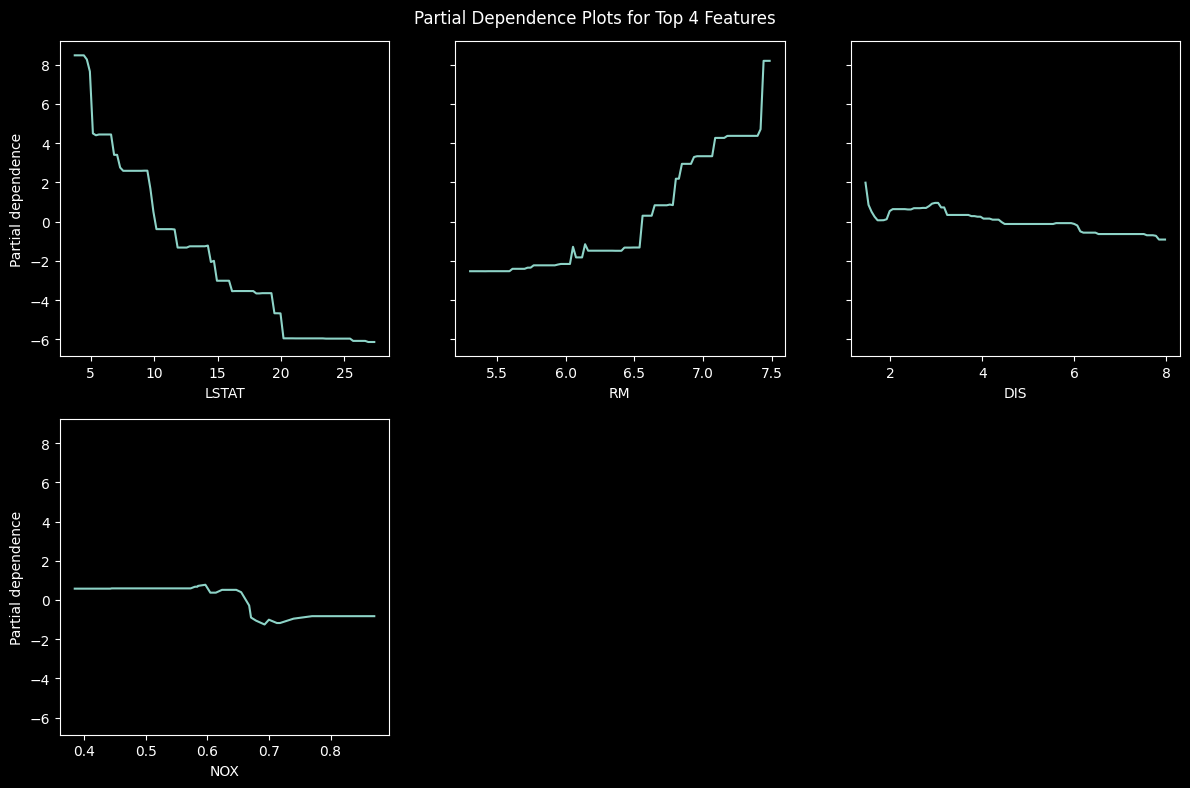

In [7]:
from sklearn.inspection import PartialDependenceDisplay

# 변수 중요도 상위 4개 변수: LSTAT, RM, DIS, CRIM
# X_train 데이터프레임의 열 인덱스를 사용합니다.
top_features = feature_importance_df['feature'].head(4).tolist()

fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
    gb_best,
    X_train,
    features=top_features,
    ax=ax
)
fig.suptitle('Partial Dependence Plots for Top 4 Features')
fig.tight_layout()
plt.show()

### 분석
- **LSTAT**: 저소득층 비율이 증가할수록 예측 집값(y축, partial dependence)이 감소하는 뚜렷한 음의 관계를 보입니다.
- **RM**: 평균 방 개수가 증가할수록 예측 집값이 상승하는 양의 관계를 보입니다.
- **DIS**: 도심 접근성이 좋을수록(값이 작을수록) 집값이 높고, 멀어질수록(값이 클수록) 집값이 낮아지는 경향을 보입니다.
- **NOX**: 이산화질소 농도가 낮은 구간에서는 집값에 큰 영향이 없다가, 특정 지점 이상으로 높아지면 집값이 하락하는 경향을 보입니다.

#### 두 변수 간의 상호작용을 보여주는 2D PDP
두 변수를 함께 사용하여 PDP를 그리면, 두 변수가 예측에 미치는 상호작용 효과를 시각화할 수 있습니다.

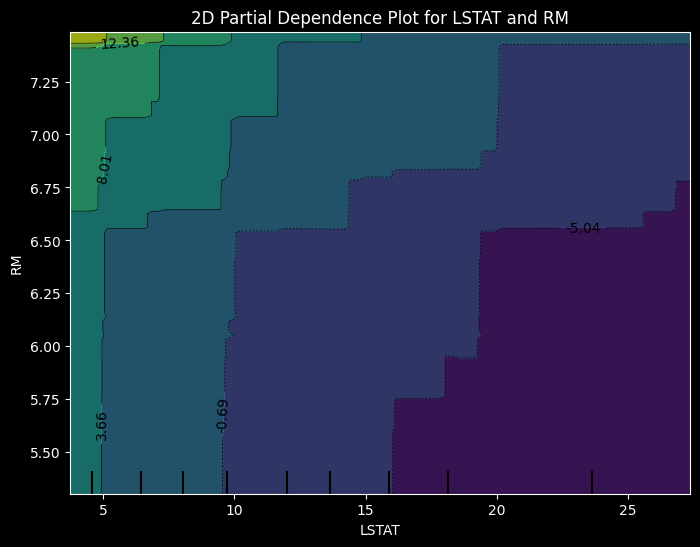

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
interaction_features = [('LSTAT', 'RM')]
display = PartialDependenceDisplay.from_estimator(
    gb_best,
    X_train,
    features=interaction_features,
    ax=ax
)
ax.set_title('2D Partial Dependence Plot for LSTAT and RM')
plt.show()

### 분석
위 등고선 그래프(heatmap)는 `LSTAT`과 `RM`의 상호작용을 보여줍니다. `RM`(방 개수)이 많고 `LSTAT`(저소득층 비율)이 낮을수록 (그래프의 오른쪽 위 영역) 예측 집값이 가장 높게 나타나고, 반대의 경우 (왼쪽 아래 영역) 가장 낮게 나타나는 것을 확인할 수 있습니다.

### 3.3. XGBoost

XGBoost는 GBM을 기반으로 **규제(Regularization)**, **병렬 처리** 등의 기능을 추가하여 성능과 속도를 크게 향상시킨 모델입니다. 과적합 방지에 강하고 높은 예측 성능을 자랑하여 데이터 분석 대회에서 널리 사용됩니다.

In [9]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', # 손실 함수 (회귀)
    booster='gbtree',             # 부스터 종류 (트리 기반)
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    colsample_bytree=0.95,      # 트리 생성 시 피처 샘플링 비율
    reg_alpha=1,                # L1 규제 (Lasso)
    reg_lambda=1,               # L2 규제 (Ridge)
    random_state=1
)

xg_reg.fit(X_train, y_train)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:CHAS: category, RAD: category

이 ValueError는 XGBoost가 데이터프레임의 'category' 데이터 타입을 기본적으로 처리하지 못해서 발생하는 문제입니다. 오류 메시지를 보면 CHAS와 RAD 열이 원인이라고 알려주고 있습니다.

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 13 to 37
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     354 non-null    float64 
 1   ZN       354 non-null    float64 
 2   INDUS    354 non-null    float64 
 3   CHAS     354 non-null    category
 4   NOX      354 non-null    float64 
 5   RM       354 non-null    float64 
 6   AGE      354 non-null    float64 
 7   DIS      354 non-null    float64 
 8   RAD      354 non-null    category
 9   TAX      354 non-null    float64 
 10  PTRATIO  354 non-null    float64 
 11  B        354 non-null    float64 
 12  LSTAT    354 non-null    float64 
dtypes: category(2), float64(11)
memory usage: 34.4 KB


``enable_categorical=True`` 파라미터를 추가

In [12]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', # 손실 함수 (회귀)
    booster='gbtree',             # 부스터 종류 (트리 기반)
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    colsample_bytree=0.95,      # 트리 생성 시 피처 샘플링 비율
    reg_alpha=1,                # L1 규제 (Lasso)
    reg_lambda=1,               # L2 규제 (Ridge)
    enable_categorical=True,  # 이 부분을 추가
    random_state=1
)

xg_reg.fit(X_train, y_train)

#####
pred_train = xg_reg.predict(X_train)
pred_test = xg_reg.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print(f'XGBoost RMSE Train: {rmse_train:.3f}, Test: {rmse_test:.3f}')


XGBoost RMSE Train: 1.321, Test: 2.870


#### XGBoost 하이퍼파라미터 튜닝 (GridSearchCV)

`GridSearchCV`를 사용하면 지정된 하이퍼파라미터 조합을 모두 테스트하여 최적의 조합을 찾을 수 있습니다. 아래 코드는 예시이며, 실제로는 더 넓은 범위의 파라미터를 탐색하거나 `RandomizedSearchCV`를 사용하는 것이 효율적일 수 있습니다.

**주의**: 아래 코드는 모든 조합을 탐색하므로 실행에 시간이 오래 걸릴 수 있습니다. `param_grid`의 일부를 주석 처리하고 실행하는 것을 권장합니다.

In [13]:
from sklearn.model_selection import GridSearchCV

# 테스트해 볼 파라미터 그리드 정의
param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 250, 500],
    'reg_lambda': [0.1, 1.0],
    'reg_alpha': [0.1, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True, random_state=1),
    param_grid=param_grid,
    cv=5, # 5-fold 교차 검증
    n_jobs=-1, # 모든 CPU 코어 사용
    verbose=2
)

# GridSearchCV 수행
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("최적의 파라미터:", grid_search.best_params_)

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"튜닝된 XGBoost 모델 RMSE: {rmse:.4f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.1; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=500, re

#### 튜닝된 XGBoost 모델의 변수 중요도 시각화

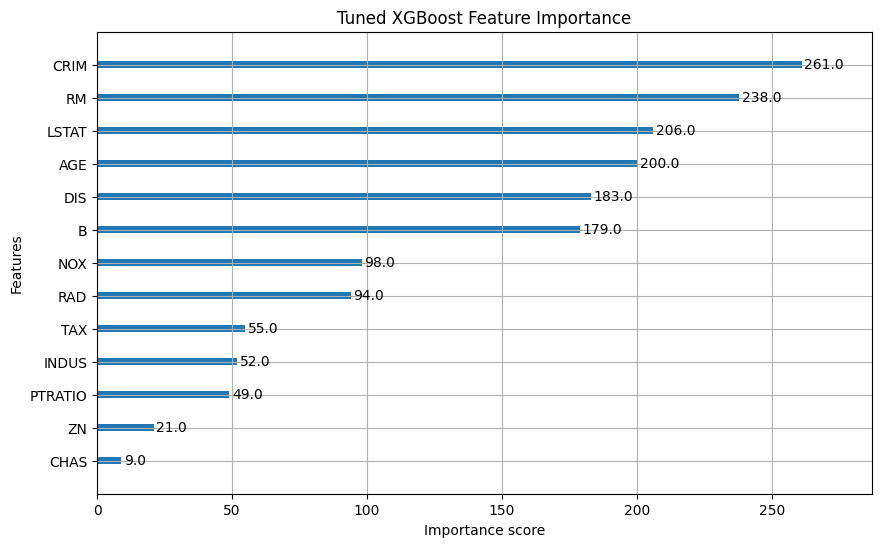

In [14]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, ax=plt.gca())
plt.title("Tuned XGBoost Feature Importance")
plt.show()

### 분석
튜닝 후 XGBoost 모델의 변수 중요도를 시각화합니다. `plot_importance`는 기본적으로 `F-score` (해당 변수가 트리를 분기하는 데 사용된 횟수)를 기준으로 중요도를 보여줍니다.

### 3.4. LightGBM

LightGBM은 XGBoost보다 더 빠른 학습 속도와 적은 메모리 사용량을 목표로 개발되었습니다. **리프 중심 트리 성장(leaf-wise growth)** 방식을 사용하여 더 빠르고 효율적으로 복잡한 트리를 생성할 수 있어 대용량 데이터에 특히 강점을 보입니다.

In [15]:
from lightgbm import LGBMRegressor

# LightGBM 모델 생성 및 훈련
lgbm_model = LGBMRegressor(n_estimators=100,
                           learning_rate=0.2,
                           max_depth=3,
                           random_state=1)

lgbm_model.fit(X_train, y_train)

# 예측 및 평가
lgbm_train_pred = lgbm_model.predict(X_train)
lgbm_test_pred = lgbm_model.predict(X_test)

lgbm_train_rmse = np.sqrt(mean_squared_error(y_train, lgbm_train_pred))
lgbm_test_rmse = np.sqrt(mean_squared_error(y_test, lgbm_test_pred))

print(f'LightGBM RMSE Train: {lgbm_train_rmse:.3f}, Test: {lgbm_test_rmse:.3f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 354, number of used features: 13
[LightGBM] [Info] Start training from score 22.339831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

### 3.5. CatBoost

CatBoost는 **Categorical Features**를 효과적으로 처리하는 데 특화된 모델입니다. **Ordered Boosting**을 사용하여 타겟 누수(Target Leakage) 문제를 해결하고 과적합을 방지합니다. 사용이 간편하고 안정적인 성능을 내는 것이 장점입니다.

In [16]:
from catboost import CatBoostRegressor

# CatBoost 모델 생성 및 훈련
catboost_model = CatBoostRegressor(iterations=500,
                                 learning_rate=0.05,
                                 depth=3,
                                 loss_function='RMSE',
                                 cat_features=['CHAS', 'RAD'],
                                 random_seed=1)

# verbose=False로 설정하여 학습 로그를 출력하지 않음
catboost_model.fit(X_train, y_train, verbose=0)

# 예측 및 평가
catboost_train_pred = catboost_model.predict(X_train)
catboost_test_pred = catboost_model.predict(X_test)

catboost_train_rmse = np.sqrt(mean_squared_error(y_train, catboost_train_pred))
catboost_test_rmse = np.sqrt(mean_squared_error(y_test, catboost_test_pred))

print(f'CatBoost RMSE Train: {catboost_train_rmse:.3f}, Test: {catboost_test_rmse:.3f}')

CatBoost RMSE Train: 1.602, Test: 2.782


### 3.6. LightGBM과 CatBoost의 변수 중요도 비교

두 모델의 변수 중요도를 시각화하여 비교해봅니다. 모델마다 변수 중요도를 계산하는 방식에 차이가 있어 결과가 조금씩 다를 수 있지만, 전반적으로 중요한 변수는 비슷하게 나타나는 경향이 있습니다.

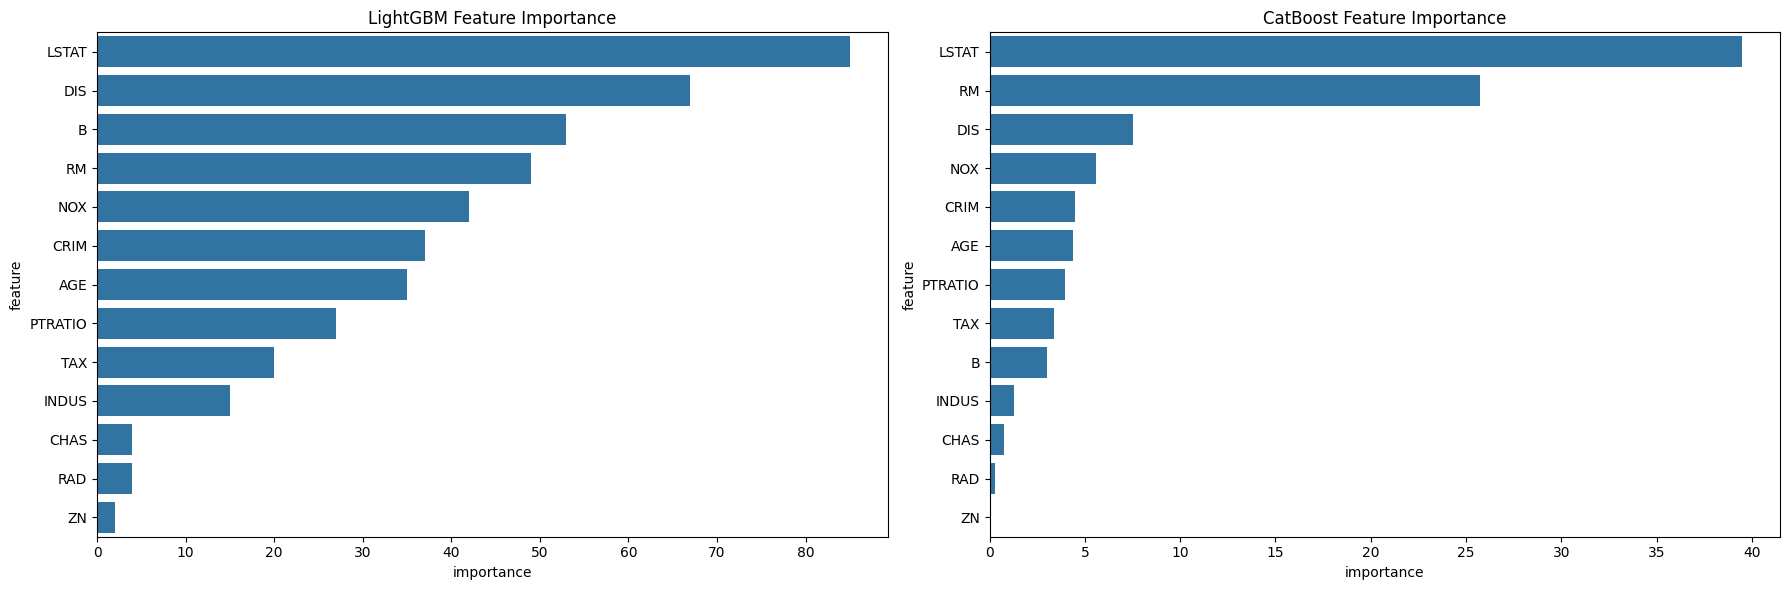

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LightGBM 특성 중요도
lgbm_imp = pd.DataFrame({'feature': X.columns, 'importance': lgbm_model.feature_importances_}).sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=lgbm_imp, ax=axes[0])
axes[0].set_title('LightGBM Feature Importance')

# CatBoost 특성 중요도
cat_imp = pd.DataFrame({'feature': X.columns, 'importance': catboost_model.feature_importances_}).sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=cat_imp, ax=axes[1])
axes[1].set_title('CatBoost Feature Importance')

plt.tight_layout()
plt.show()

## 4. 결론

이 노트북을 통해 순차적 앙상블 학습의 대표적인 모델인 GBM, XGBoost, LightGBM, CatBoost의 사용법과 결과 해석 방법을 학습했습니다.

- **GBM**은 부스팅의 기본 원리를 이해하는 데 좋은 출발점입니다.
- **XGBoost**는 강력한 성능과 규제 기능으로 안정적인 선택지입니다.
- **LightGBM**은 대용량 데이터에서 속도의 이점을 가집니다.
- **CatBoost**는 범주형 변수가 많은 데이터셋에서 별도의 전처리 없이 뛰어난 성능을 보입니다.

어떤 모델이 항상 최고라고 할 수는 없으며, 주어진 데이터와 문제의 특성에 맞게 적절한 모델을 선택하고 하이퍼파라미터를 튜닝하는 것이 중요합니다.